In [ ]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
# data transformed

### Objective
Refine Campaign population and target those high potential customers
- Classification: Identify customers with high propensity to response or sign the product
- Cluster: Segment customers and customize marketing strategy

### Load and Prepare Data

In [ ]:
import pandas as pd
import numpy as np
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

df=pd.read_csv('/kaggle/input/itaclassifier/itamcunb.csv')
df.head(5)

In [ ]:
df.BOOK.value_counts()

Imbalanced data, with 257k not responded, 51k applied not booked product, 1.2k booked product.
Further analysis may require undersampling/oversampling step to balance dataset

In [ ]:
# Impute Missing Value
print(df.columns[df.isna().any()].tolist())
df = df.fillna(df.mean())
print(df.columns[df.isna().any()].tolist())

In [ ]:
# Encode Nominal Categorical Data
categorical_feature_list = df.select_dtypes(include = 'object').columns
categorical_feature_list

In [ ]:
dfd = pd.get_dummies(df, columns=['CATG'])
print(dfd.shape)
print(dfd.select_dtypes(include = 'object').columns) #none
dfd.head(5)

### Feature Selection
Note, Tree (including RF) are sensitive to unbalanced data, balance before use RF for feature importance
- Select K best with Anova F-value
    (+ check if attributes has interaction)
- Feature importance with RF (balanced)

In [ ]:
#1. ANOVA Ftest: High F-value indicate group means are different

# label response as non-applicants, applied not booked and the final goal booked
Y = pd.get_dummies(pd.DataFrame(y), columns=['BOOK'])
Y.rename(columns = {'BOOK_-99':'NonAppl', 'BOOK_0':'NonBook', 'BOOK_1':'Book'}, inplace= True)

# ANOVA test for applicant/nonapplicant, book/nonbook 
from sklearn.feature_selection import f_classif, SelectKBest
selected_features = []
for label in ['NonAppl','NonBook','Book']:
    selector = SelectKBest(chi2, k='all')
    selector.fit(X, Y[label])
    selected_features.append(list(selector.scores_))
selected_features = pd.DataFrame(round(selected_features,0))
selected_features
# TOP attributes based on ANOVA F-value (book/nonbook)
book_fscore = selected_features.loc[[2]].rank(axis=1, ascending=False)[selected_features.loc[[2]].rank(axis=1, ascending=False)<60].dropna(axis=1).T
book_fscore.rename(columns = {2:'Fscore'}, inplace=True)
book_fscore['col']=pd.DataFrame(X.columns.tolist())
book_fscore.sort_values(by='Fscore')
# potentially select top 33 features

In [ ]:
# check correlation (interaction) among attributes
from scipy.stats.stats import pearsonr
import itertools
# remove correlated features
correlations ={}
columns = X.columns.tolist()
for col_a, col_b in itertools.combinations(columns, 2):
    correlations[col_a + ':' + col_b] = pearsonr(X.loc[:, col_a], X.loc[:, col_b])
result = pd.DataFrame.from_dict(correlations, orient='index')
result.columns = ['PCC', 'p-value']
cor_mat = pd.DataFrame(result)
cor_mat[cor_mat['p-value']<0.05][abs(cor_mat['PCC'])>0.7].sort_values(by = ['PCC'], ascending = False)

#GEN, ACCT_CNT, CNSMR_MONEY_MKT_BAL 
#EST attributes all correlated

In [ ]:
#2. Random Forest Feature Importance

# imbalance dataset
from collections import Counter
X = dfd.drop(columns = ['ID','APPL','S','SA','H','HA','BOOK'])
y = dfd['BOOK'].replace({-99:0}) # feature importance focused on Book/Nonbook
print(Counter(y))

In [ ]:
# RF model with balanced dataset (bootstrap class weighting)
from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=10, class_weight = 'balanced_subsample')
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
# summarize performance
print('Mean ROC AUC: %.3f' % mean(scores)) #0.56
# Note RF performance on balanced dataset was not good, 
# data may be sparese or non-axis-aligned (may exist diagonal decision boundary which require PCA)

In [ ]:
# RF feature importance
def print_important_variables(model, x):
    feature_list = list(x.columns)
    # Get numerical feature importances
    importances = list(model.feature_importances_)
    # List of tuples with variable and importance
    feature_importances = [(feature, importance) for feature, importance in zip(feature_list, importances)]
    # Sort the feature importances by most important first
    feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
    # Print out the feature and importances 
    return pd.DataFrame(feature_importances)

# vs = GradientBoostingClassifier(random_state=10, n_estimators=500, max_features=10, max_depth=10)
vs = RandomForestClassifier(random_state=10, n_estimators=1000, max_depth=10, class_weight='balanced_subsample')
vs = vs.fit(X, y)
vs_importance = pd.DataFrame(vs.feature_importances_, index=X.columns, columns=['importance'])\
    .sort_values(by='importance', ascending=False)
vs_importance

ANOVA feature selection shows similar with Random Forest Feature Importance, yet due to low performance of RF, may require perform SelectKBest based on selected Classifier for fine tune.

## Classification

In [ ]:
# manual balance with SMOTE
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)
# balance dataset
strategy = {-99:179983, 0:160000, 1:160000}
over = SMOTE(sampling_strategy=strategy)
# transform the dataset
X_train, y_train = over.fit_resample(X_train, y_train)
# quick test which classifier to use
from lazypredict.Supervised import LazyClassifier
clf = LazyClassifier(predictions=True)
models, predictions = clf.fit(X_train, X_test, y_train, y_test)
models


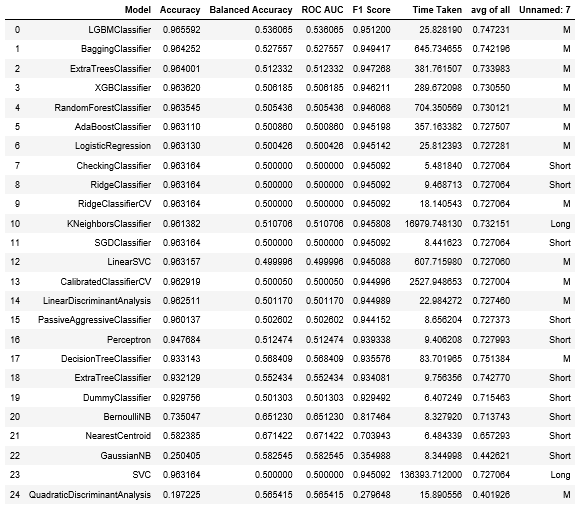

In [1]:
# due to system time not perform in kaggle
from IPython import display 
display.Image("/kaggle/input/modeltestita/modeltest1.PNG")

Naive Bayes and Nearest Centroid has highest recall and fair ROC_AUC
The goal is to target only potential customers, chose high recall to have high true predicted positive over total true positive.

### Naive Bayes improve performance
Fine tune Navie Bayes Classifier

In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.pipeline import Pipeline

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)
# balance dataset
# define pipeline
over = SMOTE(sampling_strategy=0.3)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)
# transform the dataset
X_train, y_train = pipeline.fit_resample(X_train, y_train)

# Select K Best
from sklearn.naive_bayes import (GaussianNB, CategoricalNB, BernoulliNB, MultinomialNB, ComplementNB)
from sklearn.feature_selection import f_classif, SelectKBest
pipeline = Pipeline([('selector',SelectKBest(f_classif)),
                     ('model',GaussianNB())])
search = GridSearchCV(
    estimator = pipeline,
    param_grid = {'selector__k':[25, 30, 35, 40]}, 
    #from feature selection F-value see clear cut at top 25 and after
    n_jobs=-1,
    scoring="roc_auc",
    cv=5,
    verbose=3)
search.fit(X_train, y_train)
print(search.best_params_)
print(search.best_score_)
# select 25 attributes has highest ROC_AUC score 0.8 (and high recall)

In [ ]:
# Create and fit selector
selector = SelectKBest(f_classif, k=25)
selector.fit(X_train, y_train)
# Get columns to keep and create new dataframe with those only
cols = selector.get_support(indices=True)
features_df_new = X.iloc[:,cols]
features_df_new.columns.tolist()
# similar to ANOVA F-value feature selection

#### Generalized NB: combination of Gaussian NB and BernoulliNB 
Guassian: continuous features

Bernoulli: binary features

In [ ]:
# NB do not need normalize (nor PCA as individual features are used seperately)
X_trainf = X_train.iloc[:,cols]
X_testf = X_test.iloc[:,cols]
# Gaussian (treat binary attributes as continuous)
gnb = GaussianNB()
y_pred_gs = gnb.fit(X_trainf.loc[:, X_trainf.columns.isin(continv)], y_train).predict(X_testf.loc[:, X_trainf.columns.isin(continv)])
y_pred_gs
# Gaussian performance
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, confusion_matrix,roc_curve, roc_auc_score, precision_score, recall_score, precision_recall_curve, average_precision_score
print(f'Accuracy Score: {accuracy_score(y_test,y_pred_gs)}')
print(f'Balanced Accuracy Score: {balanced_accuracy_score(y_test,y_pred_gs)}')
print(f'F1 score: {f1_score(y_test,y_pred_gs)}')
print(f'F1 Weighted score: {f1_score(y_test,y_pred_gs, average="weighted" )}')
print(f'Recall score: {recall_score(y_test,y_pred_gs)}')
print(f'Precision: {precision_score(y_test, y_pred_gs)}')
print(f'Confusion Matrix: \n{confusion_matrix(y_test, y_pred_gs)}')
print(f'Area Under Curve: {roc_auc_score(y_test, y_pred_gs)}')
print(f'PR AUC: {average_precision_score(y_test, y_pred_gs)}')

In [ ]:
binaryv = IND
continv = [x for x in X_trainf.columns.tolist() if x not in binaryv]

# Gaussian_continuous
gnb = GaussianNB()
y_prob_gs = gnb.fit(X_trainf.loc[:, X_trainf.columns.isin(continv)], y_train).predict_proba(X_testf.loc[:, X_trainf.columns.isin(continv)])
y_prob_gs

# Bernoulli_binary
bnb = BernoulliNB()
y_prob_bs = bnb.fit(X_trainf.loc[:, X_trainf.columns.isin(binaryv)], y_train).predict_proba(X_testf.loc[:, X_trainf.columns.isin(binaryv)])
y_prob_bs

y_prob_c = y_prob_gs*y_prob_bs
import numpy as np
norm = y_prob_c.T/(np.sum(y_prob_c, axis=1)+1e-6)
norm = np.moveaxis(norm, [0,1], [1,0])
norm

# generate results
print(Counter(np.argmax(norm, axis=1)))
print(np.argmax(norm, axis=1))
y_pred_c = np.argmax(norm, axis=1)

# Gaussian + Bernoulli performance
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, confusion_matrix,roc_curve, roc_auc_score, precision_score, recall_score, precision_recall_curve, average_precision_score
print(f'Accuracy Score: {accuracy_score(y_test,y_pred_c)}')
print(f'Balanced Accuracy Score: {balanced_accuracy_score(y_test,y_pred_c)}')
print(f'F1 score: {f1_score(y_test,y_pred_c)}')
print(f'F1 Weighted score: {f1_score(y_test,y_pred_c, average="weighted" )}')
print(f'Recall score: {recall_score(y_test,y_pred_c)}')
print(f'Precision: {precision_score(y_test, y_pred_c)}')
print(f'Confusion Matrix: \n{confusion_matrix(y_test, y_pred_c)}')
print(f'Area Under Curve: {roc_auc_score(y_test, y_pred_c)}')
print(f'PR AUC: {average_precision_score(y_test, y_pred_c)}')

Naive Bayes has 0.9 recall score and 0.6 AUC_ROC, generalized NB seemed to be slightly better with AUC

### Nearest Centroid improve performance

In [ ]:
# Scaler
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler() 
dfcla_ms=scaler.fit_transform(X_trainf)
dfcla_mst = scaler.transform(X_testf)
# PCA
from sklearn.decomposition import PCA
pca = PCA(10) # 10 pcas cover 99% information 
pca.fit(dfcla_ms)
np.cumsum(pca.explained_variance_ratio_)
projected = pca.transform(dfcla_ms) 
projectedt = pca.transform(dfcla_mst) 

In [ ]:
# graph top 3 pca against book
projected = pca.transform(dfcla_ms) 
pcag = pd.DataFrame(y_train)
pcag['PCA1']=projected[:, 0]
pcag['PCA2']=projected[:, 1]
pcag['PCA3']=projected[:, 2]
pcag['BOOK']=pcag['BOOK']
pcag['BOOK'].replace([1], 'BOOK', inplace=True) 
pcag['BOOK'].replace([0], 'Non-BOOK', inplace=True) 
#print(pcag.head(3))
import seaborn as sns 
#sns.pairplot(dfplot)
import matplotlib.pyplot as plt
plt.figure(figsize=(35, 35))
sns.pairplot(pcag[['BOOK', 'PCA1', 'PCA2', 'PCA3']] , hue = 'BOOK',diag_kind='kde' , plot_kws={'alpha': 0.5})

In [ ]:
# explore distance measurement for NC classifier
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise_distances.html#
# cosine out performs the rest
from sklearn.neighbors import NearestCentroid
nc = NearestCentroid(metric = 'cosine') 

nc.fit(pd.DataFrame(projected), y_train)
print(nc.centroids_)
#array([[-3.41449715e-02, -6.62887396e-04],
#       [ 9.34908224e-01, -8.38874346e-02],
#       [ 9.01799198e-01,  1.87249705e+00]])
X_testp = pd.DataFrame(projectedt)
y_pred = nc.predict(projectedt)
# performance
print(f'Accuracy Score: {accuracy_score(y_test,y_pred)}')
print(f'Balanced Accuracy Score: {balanced_accuracy_score(y_test,y_pred)}')
print(f'F1 score: {f1_score(y_test,y_pred)}')
print(f'F1 Weighted score: {f1_score(y_test,y_pred, average="weighted" )}')
print(f'Recall score: {recall_score(y_test,y_pred)}')
print(f'Precision: {precision_score(y_test, y_pred)}')
print(f'Confusion Matrix: \n{confusion_matrix(y_test, y_pred)}')
print(f'Area Under Curve: {roc_auc_score(y_test, y_pred)}')
print(f'PR AUC: {average_precision_score(y_test, y_pred)}')

In [ ]:
# Nearest Centorid do NOT output probability, estimate based on distance to centorid
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.utils.extmath import softmax
def predict_prob (self, X):
    distances=pairwise_distances(X,self.centroids_, metric=self.metric)
    probs = softmax(distances)
    return probs
dis = pd.DataFrame(predict_prob(nc, projectedt))
dis['predicted']=dis[1]

y_tpd = pd.DataFrame(y_test)
y_tpd['row'] = np.arange(y_tpd.shape[0])
dis = y_tpd.merge(dis, left_on = 'row', right_index = True)
dis['response']=dis['BOOK']
dis['group'] = 10-pd.qcut(dis['predicted'], 10, labels=False, duplicates='drop')
dis['group'] = dis['group'].max() - dis['group'] + 1
# lift table 
lift_table = dis.groupby('group').agg({'response':['count','sum'], 'predicted':['min','max']})
lift_table.columns = ['count','response','min_score','max_score']
# cumulative counts
cumulative = {}
for i in lift_table.index:
    cumulative[i] = {'cumulative_response': lift_table['response'][lift_table.index <= i].sum(),
                     'cumulative_count': lift_table['count'][lift_table.index <= i].sum()}
cumulative = pd.DataFrame(cumulative).transpose()
lift_table = pd.merge(lift_table, cumulative, left_index=True, right_index=True)
# cumulative percent, recall, accuracy, lift
total_count = len(dis)
total_response = lift_table['response'].sum()
lift_table['cumulative_percent'] = lift_table['cumulative_count'] / total_count
lift_table['cumulative_recall'] = lift_table['cumulative_response'] / total_response
lift_table['cumulative_accuracy'] = lift_table['cumulative_response'] / lift_table['cumulative_count']
lift_table['cumulative_lift'] = lift_table['cumulative_recall'] / lift_table['cumulative_percent']
lift_table

AUC improved from 0.6 to 0.7 recall reduced from 0.9 to 0.6
If advertising has high cost and wish to reduce budget by reach out to limited customers, high AUC (Nearest Centrod) should be selected and choose top precentile population as campaign refined population.
Else NB could cover more true potential customers with a cost of extended population.

## General clustering for customize marketing communication

In [ ]:
# Scaler
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler() 
dfcluster_s=scaler.fit_transform(X)
# PCA
from sklearn.decomposition import PCA
pca = PCA(10) # top 10 pcas could cover over 90% information
pca.fit(dfcluster_s)

import numpy as np
print(np.cumsum(pca.explained_variance_ratio_))

In [ ]:
# optimal number of cluster 
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

#Choosing optimal K value
cost = []
#score = []
for num_clusters in list(range(2,15)):
    km = KMeans(n_clusters=num_clusters, random_state=10) 
    preds = km.fit_predict(dfcluster_s)
    cost.append(round(km.inertia_, 4))
    #score.append(round(silhouette_score(dfcluster_s, preds),4))
    
sil = [] 
for n_clusters in list(range(2,10)):
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(dfcluster_s)
    silhouette_avg = silhouette_score(dfcluster_s, cluster_labels)
    sil.append(silhouette_avg)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

In [ ]:
# elbow optimal number of cluster (find elbow)
import matplotlib.pyplot as plt
from matplotlib import style
# elbow
plt.plot(list(range(2,15)), cost)
plt.xlabel('K')
plt.ylabel('cost function')
plt.show

In [ ]:
# silhoueete optimal number of cluster (find peak)
plt.plot(list(range(2,10)), sil)
plt.xlabel('K')
plt.ylabel('silhouette score')
plt.show

In [ ]:
from sklearn.cluster import KMeans
km = KMeans(n_clusters = 3, random_state = 10)
km.fit(projected)
cluster_3_pca = km.predict(projected)
print(pd.DataFrame(cluster_3_pca)[0].value_counts().sort_index(ascending=True))

Clustering could be used for below objective:
- Identify high quality clusters as leads (if individual score is not required and perfer reach out to customers by batch, chose cluster with higher booked penetration)
- Customize communication approach, eg. if cluster contains customer with higher engagement and deeper relationship, emphasis on loyalty program; vs cluster with less tenur, emphasis on overall branding.